In [69]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary
from neural_network import NeuralNetwork


net = NeuralNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [61]:
data_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=64, shuffle=True)


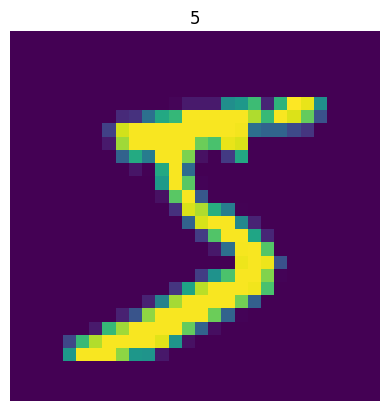

In [62]:
fig, ax = plt.subplots(1,1)
ax.imshow(data_train[0][0].view(28,28))
ax.set_title(data_train[0][1])
ax.axis('off')
plt.show()

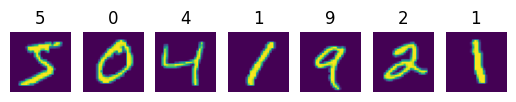

In [3]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [19]:
print(len(data_train))
print(len(data_test))


60000
10000


In [5]:
def train_epoch(net,train_loader,lr=0.01,optimizer=None,loss_fn = torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in train_loader:
        features,labels = features.to(device),labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

In [6]:
def validate(net, dataloader,loss_fn=torch.nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            features,labels = features.to(device),labels.to(device)
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [7]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.SGD(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [8]:
def plot_hist(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

Epoch  0, Train acc=0.755, Val acc=0.912, Train loss=0.013, Val loss=0.005
Epoch  1, Train acc=0.923, Val acc=0.946, Train loss=0.004, Val loss=0.003
Epoch  2, Train acc=0.948, Val acc=0.956, Train loss=0.003, Val loss=0.002
Epoch  3, Train acc=0.958, Val acc=0.963, Train loss=0.002, Val loss=0.002
Epoch  4, Train acc=0.965, Val acc=0.972, Train loss=0.002, Val loss=0.002
Epoch  5, Train acc=0.969, Val acc=0.974, Train loss=0.002, Val loss=0.001
Epoch  6, Train acc=0.972, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  7, Train acc=0.973, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  8, Train acc=0.975, Val acc=0.980, Train loss=0.001, Val loss=0.001
Epoch  9, Train acc=0.977, Val acc=0.978, Train loss=0.001, Val loss=0.001


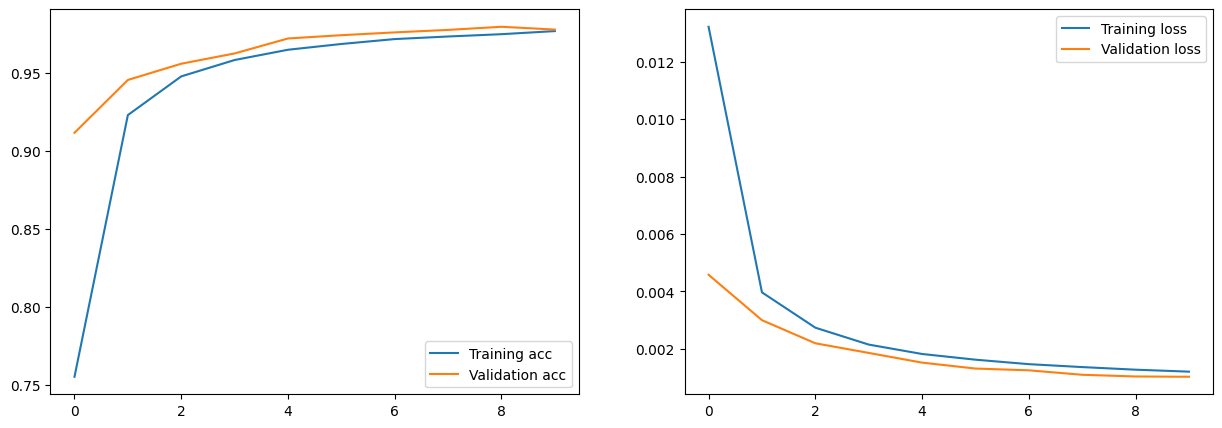

In [70]:
net.to(device)

hist = train(net,train_loader,test_loader, epochs=10)
plot_hist(hist)

In [27]:
def plot_n(image):
    figure, ax = plt.subplots(1,1)
    ax.imshow(image.view(28,28))
    ax.axis('off')
    plt.show()

In [63]:
def prepare_val_data(image_path):
    image = Image.open(image_path)
    image = transforms.Grayscale(num_output_channels=1)(image)
    image = transforms.Resize((28,28))(image)
    image = transforms.ToTensor()(image)
    plot_n(image)
    return image

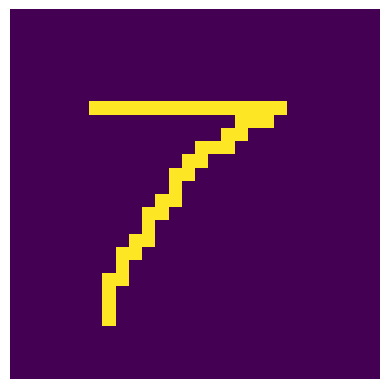

tensor([[-7.3058e+00, -7.9383e+00, -6.7889e+00, -7.3439e+00, -1.3495e+01,
         -7.1158e+00, -1.3804e+01, -6.2293e-03, -5.9774e+00, -9.7429e+00]],
       device='cuda:0')
tensor([7], device='cuda:0')


In [72]:
image_path = './validation/7.png'
image = prepare_val_data(image_path)
image = image.to(device)
net.eval()
with torch.no_grad():
    out = net(image)
print(out)
print(torch.argmax(out,dim=1))